In [1]:
%run flow_tools.py

In [2]:
folders = [box_dir + 'BadIdea/Flow/20210329 - T Cell K562/']

In [3]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Sender", "Receiver",'Ratio','Replicate'])
               for folder in folders])
df2 = clean_data(df)

In [4]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

In [5]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist.values[:,np.newaxis])
    k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Sender', 'Receiver','Ratio'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))

<Figure size 1800x1200 with 0 Axes>

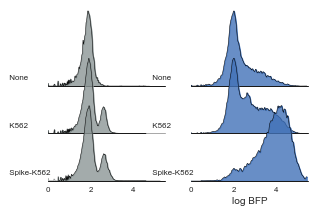

In [6]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    plt.figure(dpi=300)
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(['No Notch','SARSNotch'])) &
                               (df2['logFITC-A'] > 4)],
                      row='Sender', col = 'Receiver', sharey=False, aspect=2, height=1, 
                      hue='Receiver', row_order=['None', 'K562', 'Spike-K562'], xlim=[0, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'tcell_cell-cell_histogram.svg')

In [7]:
filters = ((df2['logFITC-A'] > 4) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Sender','Receiver','Computed Density','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [47]:
receivers = ['SARSNotch', 'No Notch']
senders = ['K562', 'Spike-K562']
colors = {'No Notch + K562' : '#8C9696',
          'No Notch + Spike-K562' : '#6F7978',
          'SARSNotch + K562' : '#4272B8',
          'SARSNotch + Spike-K562' : '#2158A4'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}
markers = {'K562' : 'o', 'Spike-K562': '^'}
ratios = ['1:1', '2:1', '4:1', '8:1']

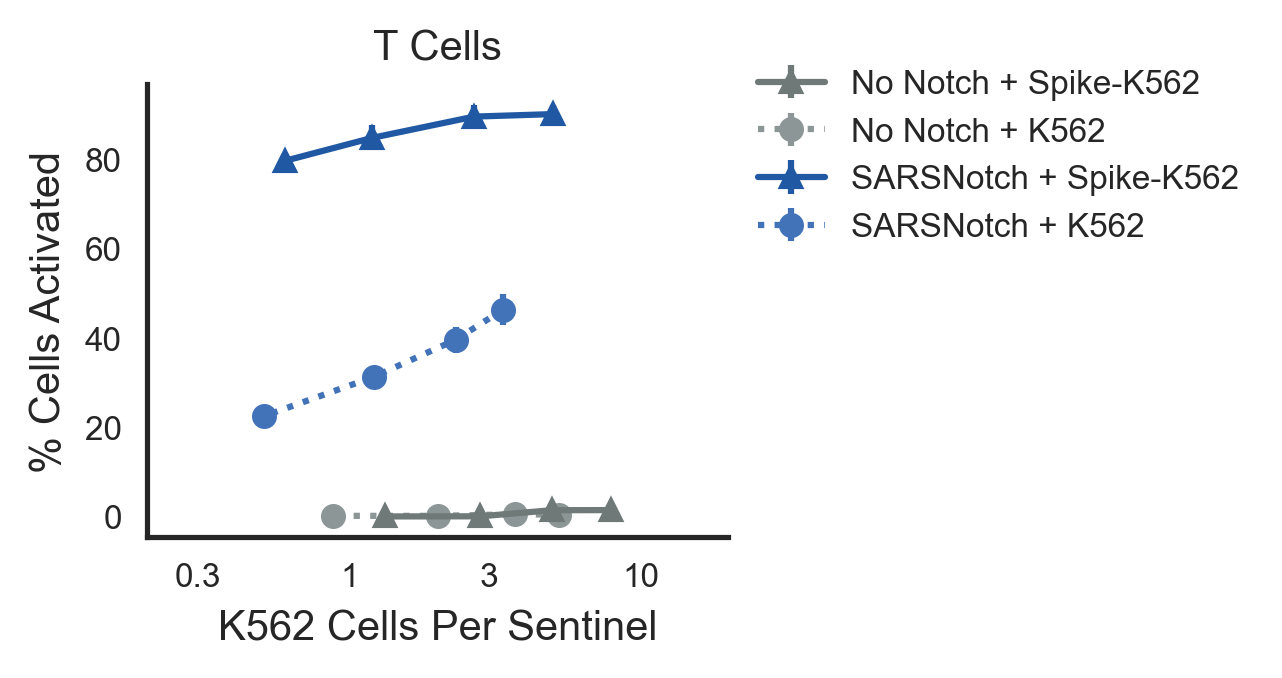

In [50]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = summary[(summary['Receiver']==receiver) & (summary['Sender']==sender)]
    output = (condition_summary
              .groupby('Computed Density')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Computed Density', ascending=False))
    ax.errorbar(output['Computed Density'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver + ' + ' + sender], 
                label=f'{receiver} + {sender}',
                marker=markers[sender], markersize=5, ls=linestyles[sender])

ax.set_xlabel('K562 Cells Per Sentinel')
ax.set_ylabel('% Cells Activated')
ax.set_xscale('log')
ax.set_xlim([2e-1,2e1])
ax.set_xticks([0.3, 1, 3, 10])

def pretty_decimals(x, pos):
    return str(round(x, 1) if x % 1 else int(x))

ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(pretty_decimals))

plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.1))
sns.despine()
plt.title('T Cells')
plt.savefig(outputdir + 'tcells_cell_cell.svg')

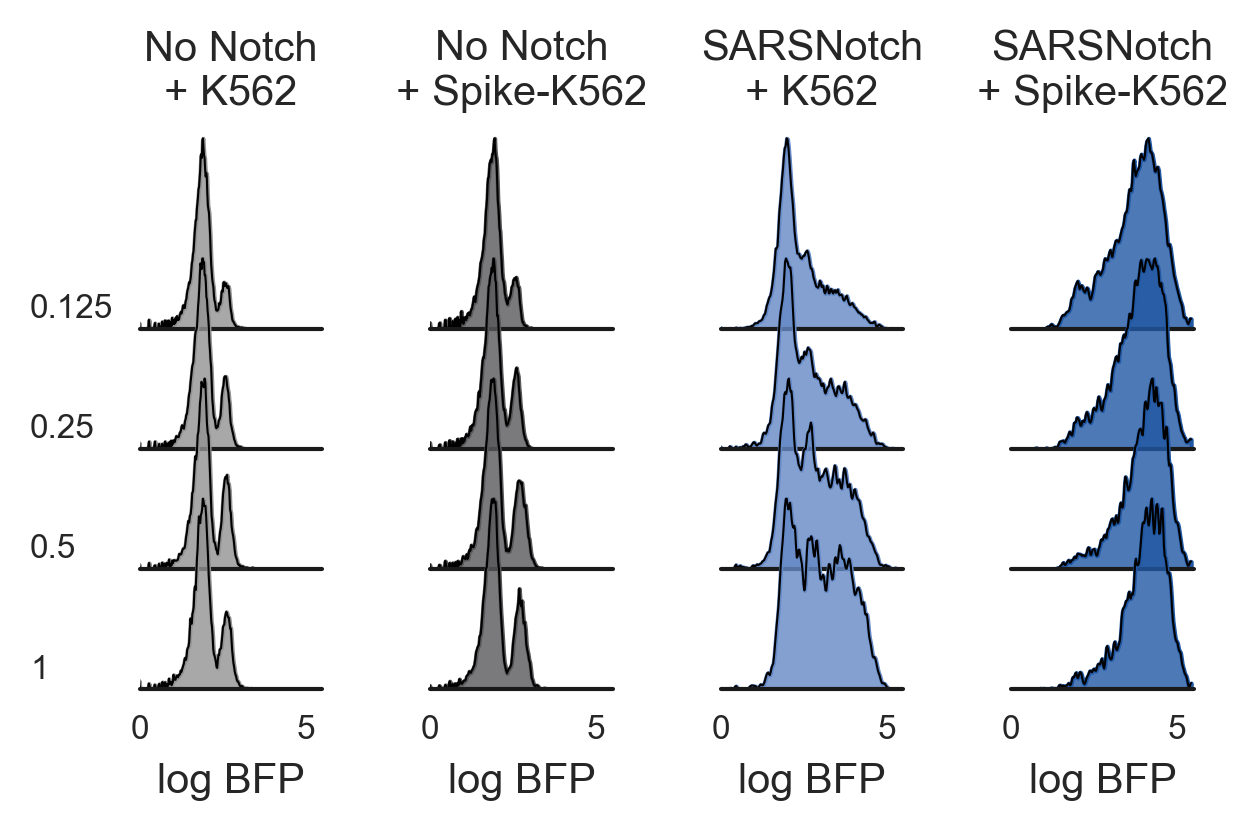

In [17]:
df2['Receiver/Sender'] = df2['Receiver'] + '\n+ ' + df2['Sender']
with sns.color_palette(["#949394",'#59585A', '#6489C6', "#2158A4"]):
    senders = ['K562', 'Spike-K562']
    notches = ['No Notch','SARSNotch']
    pairs = ['No Notch\n+ K562', 'No Notch\n+ Spike-K562', 'SARSNotch\n+ K562', 'SARSNotch\n+ Spike-K562']
    densities = ['0.125', '0.25', '0.5', '1']
    ratio_order = ['8:1', '4:1', '2:1','1:1']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Sender']).isin(senders) &
                               (df2['Ratio'] != 'None') &
                               (df2['logFITC-A'] > 4)],
                      row='Ratio', col = 'Receiver/Sender', sharey=False, aspect=1.5, height=0.65, 
                      hue='Receiver/Sender',col_order=pairs, hue_order=pairs, row_order = ratio_order, xlim=[0, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    left_axes = [g.facet_axis(r, 0) for r in range(len(densities))]
    for ax, density in zip(left_axes, densities):
        ax.text(-0.6,0.1, "{}".format(density), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(pairs))]
    for ax, pair in zip(top_axes, pairs):
        ax.set_title(pair)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.set_xlabels("log BFP")
    g.fig.set_dpi(300)
    plt.savefig(outputdir+'tcell_cell-cell_histogram.svg')